# FCCee Analysis Examples
Using the example `higgs/mH-recoil/mumu` from [FCCAnalyses](https://github.com/HEP-FCC/FCCAnalyses)

In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Development/EDM4hep.jl/examples/FCC`
Precompiling project...
  ✓ EDM4hep
  1 dependency successfully precompiled in 14 seconds. 222 already precompiled.


In [2]:
using EDM4hep
using EDM4hep.RootIO
using EDM4hep.SystemOfUnits
using EDM4hep.Histograms

[ Info: Precompiling EDM4hep [eb32b910-dde9-4347-8fce-cd6be3498f0c]


## Definition of some analysis functions
These are couple of examples of high-level functions that makes use of `ReconstructedParticle` objects to build resonances and recoils. They make use of standard Julia functions to generate combinations, to sort a vector, and to work with LorentzVectors.  

In [3]:
# re-using convenient existing packages 
using LorentzVectorHEP
using Combinatorics

"""
    resonanceBuilder(rmass::AbstractFloat, legs::AbstractVector{ReconstructedParticle})

Returns a container with the best resonance of 2 by 2 combinatorics of the `legs` container
sorted by closest to the input `rmass` in absolute value.
"""
function resonanceBuilder(rmass::AbstractFloat, legs::AbstractVector{ReconstructedParticle})
    result = ReconstructedParticle[]
    length(legs) < 2 && return result
    for (a,b) in combinations(legs, 2)
        lv = LorentzVector(a.energy, a.momentum...) + LorentzVector(b.energy, b.momentum...)
        rcharge = a.charge + b.charge
        push!(result, ReconstructedParticle(mass=mass(lv), momentum=(lv.x, lv.y, lv.z), charge=rcharge))
    end
    sort!(result, lt =  (a,b) -> abs(rmass-a.mass) < abs(rmass-b.mass))
    return result[1:1]  # take the best one
end;

"""
    recoilBuilder(comenergy::AbstractFloat, legs::AbstractVector{ReconstructedParticle})

    build the recoil from an arbitrary list of input `ReconstructedParticle`s and the center of mass energy.
"""
function recoilBuilder(comenergy::AbstractFloat, in::AbstractVector{ReconstructedParticle})
    result = ReconstructedParticle[]
    isempty(in) && return result
    recoil_lv = LorentzVector(comenergy, 0, 0, 0)
    for p in in
        recoil_lv -= LorentzVector(p.mass, p.momentum...)
    end
    push!(result, ReconstructedParticle(mass=mass(recoil_lv), momentum=(recoil_lv.x, recoil_lv.y, recoil_lv.z)))
    return result
end;

## Defining the resulting analysis data
We create a custom structure with all summary information of each event.

In [4]:
using DataFrames

mutable struct AnalysisData
    df::DataFrame
    pevts::Int64
    sevts::Int64
    AnalysisData() = new(DataFrame(Zcand_m = Float32[], Zcand_recoil_m = Float32[], Zcand_q = Int32[], Zcand_recoil_θ = Float32[]), 0, 0)
end
function Base.empty!(data::AnalysisData)
    empty!(data.df)
    data.pevts = 0
    data.sevts = 0
end
function Base.append!(d1::AnalysisData, d2::AnalysisData)
    append!(d1.df, d2.df)
    d1.pevts += d2.pevts
    d1.sevts += d2.sevts
end

## Open the data file to get the events
- It is using a file in EOS with the `root:` protocol
- The obtained `events` is a `LazyTree` created by the [UnROOT.jl](https://github.com/JuliaHEP/UnROOT.jl) package. As the name indicates no event is actually read yet.

In [5]:
f = "root://eospublic.cern.ch//eos/experiment/fcc/ee/generation/DelphesEvents/winter2023/IDEA/p8_ee_ZZ_ecm240/events_000189367.root"
#f = "/Users/mato/cernbox/Data/events_000189367.root"
reader = RootIO.Reader(f);
events = RootIO.get(reader, "events");

reader

┌───────────────┬───────────────────────────────────────────────────────────────
│ Atribute      │ Value                                                        ⋯
├───────────────┼───────────────────────────────────────────────────────────────
│ File name     │ root://eospublic.cern.ch//eos/experiment/fcc/ee/generation/D ⋯
│ # of events   │ 100000                                                       ⋯
│ IO Format     │ TTree                                                        ⋯
│ PODIO version │ 0.16.2                                                       ⋯
│ ROOT version  │ 6.26.6                                                       ⋯
└───────────────┴───────────────────────────────────────────────────────────────
                                                                1 column omitted
┌──────────────────────┬───────────────────────────┬──────────────┐
│ BranchName           │ Type                      │ CollectionID │
├──────────────────────┼───────────────────────────┼──

## Loop over events and fill the DataFrame

In [6]:
function myanalysis!(data::AnalysisData, events)
    for evt in events
        data.pevts += 1
        #---get the collection of Muons and ReconstructedParticles
        muids = StructArray{ObjectID{ReconstructedParticle}, Symbol("Muon#0")}(evt)
        length(muids) < 2 && continue
        recps = StructArray{ReconstructedParticle, :ReconstructedParticles}(evt)
        muons = recps[muids]  # use the objectids to collect the referenced ReconstructedParticles
        sel_muons = filter(x -> pₜ(x) > 10GeV, muons)
        zed_leptonic = resonanceBuilder(91GeV, sel_muons)
        zed_leptonic_recoil = recoilBuilder(240GeV, zed_leptonic)
        if length(zed_leptonic) == 1    #  Filter to have exactly one Z candidate
            Zcand_m        = zed_leptonic[1].mass
            Zcand_recoil_m = zed_leptonic_recoil[1].mass
            Zcand_recoil_θ = zed_leptonic_recoil[1].momentum |> EDM4hep.θ
            Zcand_q        = zed_leptonic[1].charge
            
            if 80GeV <= Zcand_m <= 100GeV
                push!(data.df, (Zcand_m, Zcand_recoil_m, Zcand_q, Zcand_recoil_θ))
                data.sevts += 1
            end
        end
    end
    return data
end

myanalysis! (generic function with 1 method)

In [7]:
data = AnalysisData()
N = Threads.nthreads()

function process_mt(data, events)
    empty!(data)
    
    # Chunk the total number of events to process
    chunks = Iterators.partition(events, length(events) ÷ (4 * N))
    
    # Spawn the tasks
    tasks = map(chunks) do chunk
        Threads.@spawn myanalysis!(AnalysisData(), chunk)
    end
    
    # Wait and sum the reduce the results
    results = fetch.(tasks)
    append!.(Ref(data), results);
    
end

function process_serial(data, events)
    empty!(data)
    myanalysis!(data, events)
end

process_serial (generic function with 1 method)

In [9]:
elapsed1 = @elapsed process_serial(data,events)
println("Serial: total time: $elapsed1, $(data.pevts/elapsed1) events/s. Selected events: $(data.sevts)")

elapsed2 = @elapsed process_mt(data,events)
println("MT[$N]: total time: $elapsed2, $(data.pevts/elapsed2) events/s. Selected events: $(data.sevts)")
println("Speeedup: $(elapsed1/elapsed2)")

Serial: total time: 19.20679725, 5206.490113805934 events/s. Selected events: 5008
MT[4]: total time: 12.083079542, 8276.035894029043 events/s. Selected events: 5008
Speeedup: 1.589561434503383


## Plot the results

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
Precompiling FHistPlotsExt
  ✓ FHist → FHistPlotsExt
  ✓ Plots → UnitfulExt
  2 dependencies successfully precompiled in 45 seconds. 160 already precompiled.
[ Info: Precompiling FHistPlotsExt [1de79d59-983d-5d48-95ce-9cb7bda22df6]
┌ Warning: Module Plots with build ID fafbfcfd-41ca-955a-0005-93c4a5f29ea6 is missing from the cache.
│ This may mean Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1942
[ Info: Skipping precompilation since __precompile__(false). Importing FHistPlotsExt [1de79d59-983d-5d48-95ce-9cb7bda22df6].
[ Info: Precompiling UnitfulExt [0e51ec96-f580-5f12-a625-1297083d7970]
┌ Warning: Module Plots with build ID fafbfcfd-41ca-955a-0005-93c4a5f29ea6 is missing from the cache.
│ This may mean Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] does not support precompilation but is imported by a module that does.
└ @ Base load

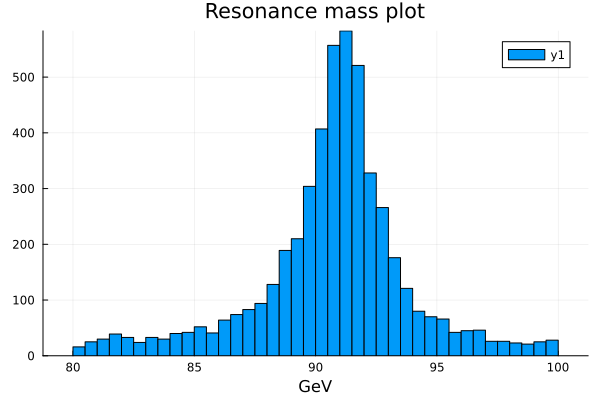

In [10]:
using Plots
histogram(data.df.Zcand_m, title="Resonance mass plot",xlabel="GeV")

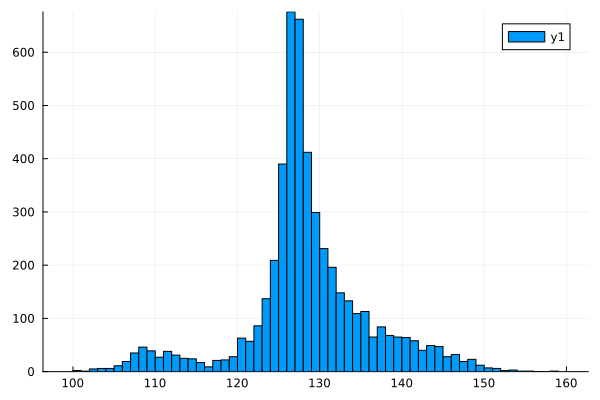

In [11]:
histogram(data.df.Zcand_recoil_m)

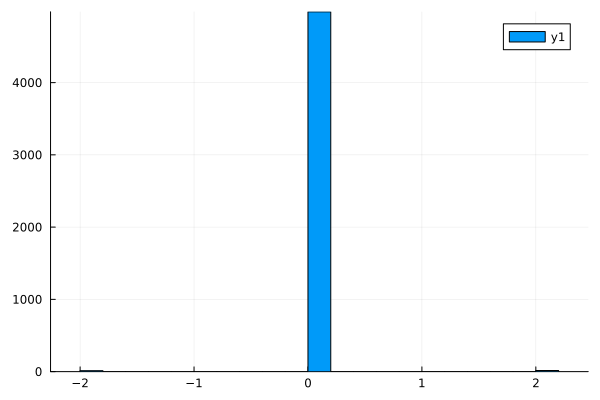

In [12]:
histogram(data.df.Zcand_q)

In [13]:
using Parquet2
Parquet2.writefile("m_H-recoil.parquet", data.df)

[ Info: Precompiling Parquet2 [98572fba-bba0-415d-956f-fa77e587d26d]
[ Info: Precompiling ArraysOfArraysAdaptExt [61a48756-deb8-5b59-adae-48b93e2c28cf]
[ Info: Precompiling BangBangStructArraysExt [d139770a-8b79-56c4-91f8-7273c836fd96]
[ Info: Precompiling BangBangDataFramesExt [d787bcad-b5c5-56bb-adaa-6bfddb178a59]
[ Info: Precompiling TransducersDataFramesExt [cefb4096-3352-5e5f-8501-71f024082a88]


✏ Parquet2.FileWriter{IOStream}(m_H-recoil.parquet)